# Тестовое задание для позиции data scientist в SCORR
## Стенина Мария Михайловна

Текст задания по ссылке https://docs.google.com/document/d/1Ame5oV-CMoIP-ncC2Qc_sXSwQST0CXcV7PwKqQBy6VE

Пункты 3  и 4.

In [1]:
%pylab inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Предсказание города 

Для быстрого сбора статистики заводим словарь, ключами в котором будут id, значениями - строки с городами. И такой же словарь с датами рождения.

In [3]:
files = os.listdir('vertices')
birth_dates = {}
cities = {}
for filename in files:
    for string in open('vertices/' + filename):
        string = string.rstrip().lstrip()
        values = string.split(';')
        user = int(values[0])
        birth_dates[user] = values[2]
        cities[user] = values[3]

Все пользователи делятся на три группы: 
- город не указан
- указан один город
- указано более одного города

Чтобы избежать неоднозначности будем предсказывать город только для тех пользователей, у которых он указан в единственном экземпляре. Если же у друга указано несколько городов, то будем считать, что он из всех этих городов одновременно. Если у пользователя не указан город или нет друзей с указанными городами, в этом пункте задания такой пользователь не рассматривается.

Город - признак категориальный, его значения нельзя сравнивать. Можно использовать кодирование категориальных признаков, а затем строить на этих признаках многоклассовый классификатор. Но, скорее всего, мой компьютер такое не потянет, да и классификатор такой будет выбирать наиболее популярный город у друзей. Поэтому начну с самого простого: с оценки в какой доле случаев город у пользователя совпадает с самым частым городом, встречающимся у друзей, со вторым по частоте, и т.д.

Сразу оговорю недостатки моего метода. Названия городов будут сравниваться посимвольно. Это значит, что один и тот же город, названия которого записаны латиницей и кириллицей, будет распознаваться как два разных города. Также варианты названия одного города (Санкт-Петербург, Петербург, Питер, СПб) будут считаться разными городами. Географическая близость городов тоже никак не учитывается.

In [6]:
def GetCity (city_string):
    """
    Return empty string if there is no city,
    return list contains string with city name if there is one city
    return list of strings if there are two or more cities
    """
    
    if len(city_string) == 0:
        return city_string
    
    return city_string.split('|')

In [45]:
users_city = []
friends_city_top = []

for filename in files:
    for s_friends in open('adjacency_list/' + filename):
        s_friends = s_friends.strip()
        [source, destinations] = s_friends.split('Set')
        source = int(source[1:-1])
        try:
            city = GetCity(cities[source]) 
        except KeyError:
            continue
        if city == '' or len(city) > 1:
            continue
        
        friends = map(int, destinations[1:-2].split(','))
        friends_number = len(friends)
        if friends_number == 0:
            continue
            
        friends_with_city = 0
        friends_cities = []
        for friend in friends:
            try:
                friend_city = GetCity(cities[friend])
            except KeyError:
                continue
            if friend_city != '':
                friends_cities.extend(friend_city)
                friends_with_city += 1
        if friends_with_city > 0:
            users_city.append(city[0])
            unique_cities, counts = np.unique(friends_cities, return_counts=True)
            counts_argsort = np.argsort(counts)
            top_cities = unique_cities[counts_argsort[-1:-10:-1]]
            if len(top_cities) < 10:
                top_cities = list(top_cities) + [None] * (10 - len(top_cities))
            else:
                top_cities = list(top_cities)
            friends_city_top.append(top_cities + [friends_number, friends_with_city])
friends_city_top = np.array(friends_city_top)

In [48]:
cities_data_frame = pd.DataFrame(data=friends_city_top, columns=['top_1', 'top_2', 'top_3', 'top_4', 'top_5',
                                                                'top_6', 'top_7', 'top_8', 'top_9', 'top_10', 'friends', 
                                                                'friends_with_city'])
cities_data_frame['target'] = list(users_city)
cities_data_frame.to_csv('CityDataFrame.csv', index=False)

## Корреляция города у пользователя с городами его друзей

In [53]:
equal_fraction = []
for top in cities_data_frame.columns[:10]:
    equal_fraction.append(np.mean(cities_data_frame[top] == cities_data_frame.target))

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text yticklabel objects>)

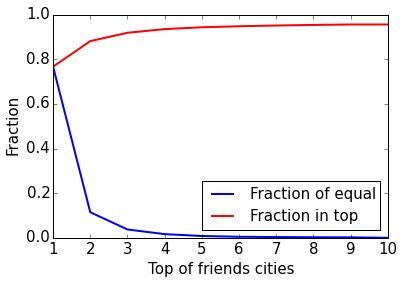

In [55]:
plt.plot(range(1, 11), equal_fraction, 'b-', linewidth=2)
plt.plot(range(1, 11), np.cumsum(equal_fraction), 'r-', linewidth=2)
plt.legend(('Fraction of equal', 'Fraction in top'), fontsize=15, loc=0)
plt.xlabel('Top of friends cities', fontsize=15)
plt.ylabel('Fraction', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [56]:
print np.cumsum(equal_fraction)

[ 0.76676919  0.88125929  0.91858175  0.93510039  0.94315237  0.94774856
  0.95120434  0.95362339  0.95569686  0.95569686]


Город, указанный на странице у пользователя, совпадает с самым частым городом у его друзей в $76\%$ случаев. В почти $92\%$ случаев город пользователя попадает в топ-3 самых популярных городов его друзей. В десяток город пользователя попадает в $95.5\%$ случаев.

Есть гипотеза, что друзья одного возраста как правило из одного города. Для проверки этой гипотезы построим аналогичные графики, информация для которых будет собрана по друзьям, разница в возрасте с которыми у пользователя не более 2 лет. В этом случае выборка будет меньше, так как даты рождения указаны не у всех.

In [57]:
import datetime

def GetYearOfBirth (birth_dates):
    """
    return year of birth if it is correct and -1 otherwise
    """
    if len(birth_dates) == 0:
        return -1
    
    dates = birth_dates.split('|')
    current_year = datetime.date.today().year
    if len(dates) == 1:
        [year, month, day] = dates[0].split('-')
        if year != '0000' and 5 <= current_year - int(year) <= 70:
            return int(year)
        else:
            return -1
            
    else:
        dates_parced = np.array([date.split('-') for date in dates])
        if np.all(dates_parced[:, -1] == dates_parced[0, -1]) and np.all(dates_parced[:, 1] == dates_parced[0, 1]):
            for year in dates_parced[:, 0]:
                if year != '0000':
                    break
            if np.all(np.logical_or(dates_parced[:, 0] == '0000', dates_parced[:, 0] == year)):
                if 5 <= current_year - int(year) <= 70:
                    return int(year)
                else:
                    return -1
            else:
                return -1
        else:
            return -1

In [63]:
users_city = []
friends_city_top = []

for filename in files:
    for s_friends in open('adjacency_list/' + filename):
        s_friends = s_friends.strip()
        [source, destinations] = s_friends.split('Set')
        source = int(source[1:-1])
        try:
            city = GetCity(cities[source]) 
        except KeyError:
            continue
        if city == '' or len(city) > 1:
            continue
        try:
            year = GetYearOfBirth(birth_dates[source]) 
        except KeyError:
            continue
        if year == -1:
            continue
        
        friends = map(int, destinations[1:-2].split(','))
        friends_number = len(friends)
        if friends_number == 0:
            continue
            
        friends_with_city_and_date = 0
        friends_cities = []
        for friend in friends:
            try:
                friend_city = GetCity(cities[friend])
            except KeyError:
                continue
            try:
                friend_year = GetYearOfBirth(birth_dates[friend])
            except KeyError:
                continue
            if year == -1:
                continue
                
            if friend_city != '':
                friends_cities.extend(friend_city)
                friends_with_city_and_date += 1
        if friends_with_city_and_date > 0:
            users_city.append(city[0])
            unique_cities, counts = np.unique(friends_cities, return_counts=True)
            counts_argsort = np.argsort(counts)
            top_cities = unique_cities[counts_argsort[-1:-10:-1]]
            if len(top_cities) < 10:
                top_cities = list(top_cities) + [None] * (10 - len(top_cities))
            else:
                top_cities = list(top_cities)
            friends_city_top.append(top_cities + [friends_number, friends_with_city_and_date])
friends_city_top = np.array(friends_city_top)

In [64]:
cities_data_frame_with_date = pd.DataFrame(data=friends_city_top, columns=['top_1', 'top_2', 'top_3', 'top_4', 'top_5',
                                                                'top_6', 'top_7', 'top_8', 'top_9', 'top_10', 'friends', 
                                                                'friends_with_city_and_date'])
cities_data_frame_with_date['target'] = list(users_city)
cities_data_frame_with_date.to_csv('CityDataFrameWithDate.csv', index=False)

In [65]:
equal_fraction_date = []
for top in cities_data_frame_with_date.columns[:10]:
    equal_fraction_date.append(np.mean(cities_data_frame_with_date[top] == cities_data_frame_with_date.target))

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text yticklabel objects>)

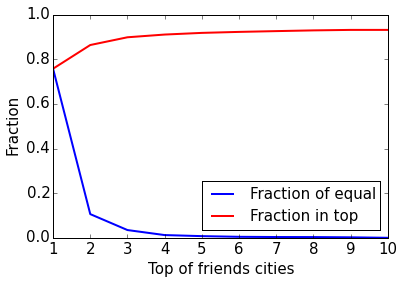

In [66]:
plt.plot(range(1, 11), equal_fraction_date, 'b-', linewidth=2)
plt.plot(range(1, 11), np.cumsum(equal_fraction_date), 'r-', linewidth=2)
plt.legend(('Fraction of equal', 'Fraction in top'), fontsize=15, loc=0)
plt.xlabel('Top of friends cities', fontsize=15)
plt.ylabel('Fraction', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [67]:
print np.cumsum(equal_fraction_date)

[ 0.75758519  0.86370002  0.89839739  0.91061148  0.91807998  0.92251439
  0.92601525  0.92928271  0.93146102  0.93146102]


Город стал предсказываться хуже, чем при первом варианте. Гипотеза не подтвердилась.

Построим графики зависимости доли совпадений города у пользователя от количества друзей и возраста пользователя. Для этого нужно составить еще одну таблицу, в которую войдут пользователи с указанным годом рождения и городом.

In [68]:
users_city = []
friends_city_top = []

for filename in files:
    for s_friends in open('adjacency_list/' + filename):
        s_friends = s_friends.strip()
        [source, destinations] = s_friends.split('Set')
        source = int(source[1:-1])
        try:
            city = GetCity(cities[source]) 
        except KeyError:
            continue
        if city == '' or len(city) > 1:
            continue
        try:
            year = GetYearOfBirth(birth_dates[source]) 
        except KeyError:
            continue
        if year == -1:
            continue
        
        friends = map(int, destinations[1:-2].split(','))
        friends_number = len(friends)
        if friends_number == 0:
            continue
            
        friends_with_city = 0
        friends_cities = []
        for friend in friends:
            try:
                friend_city = GetCity(cities[friend])
            except KeyError:
                continue
                
            if friend_city != '':
                friends_cities.extend(friend_city)
                friends_with_city += 1
        if friends_with_city > 0:
            users_city.append(city[0])
            unique_cities, counts = np.unique(friends_cities, return_counts=True)
            counts_argsort = np.argsort(counts)
            top_cities = unique_cities[counts_argsort[-1:-10:-1]]
            if len(top_cities) < 10:
                top_cities = list(top_cities) + [None] * (10 - len(top_cities))
            else:
                top_cities = list(top_cities)
            friends_city_top.append(top_cities + [friends_number, friends_with_city, year])
friends_city_top = np.array(friends_city_top)

In [70]:
cities_data_frame_years = pd.DataFrame(data=friends_city_top, columns=['top_1', 'top_2', 'top_3', 'top_4', 'top_5',
                                                                'top_6', 'top_7', 'top_8', 'top_9', 'top_10', 'friends', 
                                                                'friends_with_city', 'year'])
cities_data_frame_years['target'] = list(users_city)
cities_data_frame_years.to_csv('CityDataFrameYear.csv', index=False)

In [71]:
def ResearchEqualsQuantiles (y_true, y_pred, feature, bins):
    cuts = np.percentile(feature, np.linspace(0, 100, num=bins+1))
    fraction = np.zeros(bins)
    for i in xrange(bins):
        bin_idx = np.logical_and(feature >= cuts[i], feature < cuts[i+1])
        fraction[i] = np.mean(y_true[bin_idx] == y_pred[bin_idx])
    return fraction, (cuts[:-1] + cuts[1:]) / 2

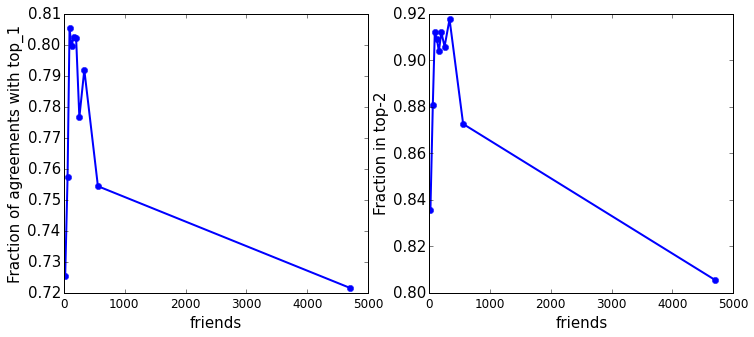

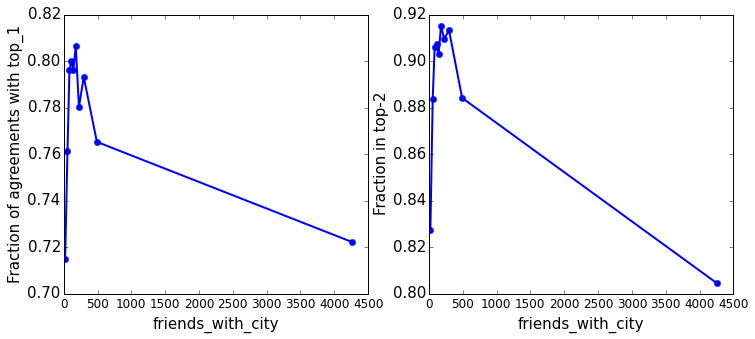

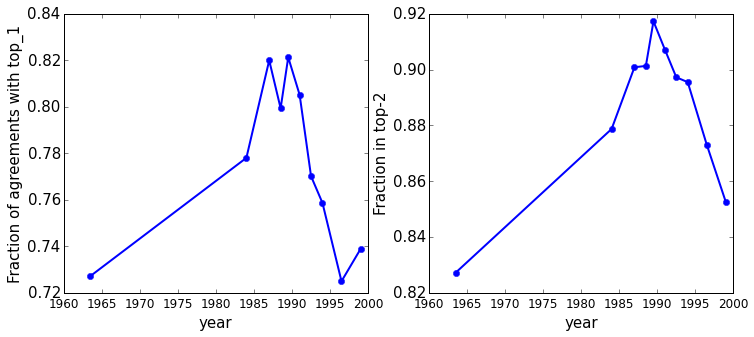

In [77]:
for feature in ['friends', 'friends_with_city', 'year']:
    equal_fraction, feature_values = ResearchEqualsQuantiles(cities_data_frame_years.top_1, cities_data_frame_years.target,
                                                            cities_data_frame_years[feature].values, bins=10)
    equal_fraction_2, feature_values = ResearchEqualsQuantiles(cities_data_frame_years.top_2, cities_data_frame_years.target,
                                                            cities_data_frame_years[feature].values, bins=10)
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(feature_values, equal_fraction, 'b-', linewidth=2)
    plt.plot(feature_values, equal_fraction, 'b.', ms=12)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Fraction of agreements with top_1', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    
    plt.subplot(122)
    plt.plot(feature_values, equal_fraction + equal_fraction_2, 'b-', linewidth=2)
    plt.plot(feature_values, equal_fraction + equal_fraction_2, 'b.', ms=12)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Fraction in top-2', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)

Наибольшая доля попаданий реального города как в топ-1, так и в топ-2 городов у друзей приходится на пользователей с годом рождения от 1985 по 1992. Надежность предсказания города также зависит и от количества друзей. Наилучшие показатели при количестве друзей от 100 до 400 (как с указанным городом, так и нет). Скорее всего, у этих пользователей почти все друзья указали город, поэтому цифры не отличаются.

## Выводы по предсказанию города

В большинстве случаев город, указанный пользователем на странице, совпадает с наиболее часто встречающимся городом у его друзей. И почти всегда попадает в десятку наиболее частых городов у друзей. Поэтому предсказывать город для пользователя исходя из анализа распределения городов его друзей можно.

Наиболее точно город по таким признакам можно определить для пользователей с годами рождения с 1985 по 1992 и для пользователей, имеющих в сети от 100 до 400 друзей. Если друзей больше, то, вероятнее всего, степень дружбы между ними и пользователем невелика, поэтому точность предсказания города снижается. 

# Метрика для ранжирования по степени дружбы

Поскольку данных для оценки качества ранжирования в данной выборке нет, ограничусь только рассуждением, какие факторы я бы учитывала в такой метрике.
- Разница в возрасте, чем она больше, тем, скорее всего, менее близки люди.
- Город, если он совпадает, или города географически близки, то степень дружбы больше.
- Количество общих друзей, чем больше, тем более близки люди.
- Количество общих друзей из города пользователя.
- Количество ребер дружбы между общими друзьями (школьные классы или студенческие группы должны образовывать в графе клики).

Веса между всеми этими параметрами необходимо настраивать в эксперименте.